# Initialize

In [57]:
from pupil_apriltags import Detector, Detection
from collections import defaultdict
from typing import List, Dict, Tuple, Any
from glob import glob
import numpy as np
import os
import time
import sys
import cv2
from math import atan2, degrees
import platform
import socket
import matplotlib.pyplot as plt
import math
from statsFuncs import trigonometry as trig
from statsFuncs import numbers
import pandas as pd
import utils
import multiprocessing
from joblib import Parallel, delayed
from numpy import save
import pupil_functions
import decimal
import pickle
from find_blob import find_blob
%run trackingdelay.ipynb

%load_ext autoreload
%autoreload 2

trackingdelay.ipynb:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "source": [
trackingdelay.ipynb:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "from pupil_functions import *"
trackingdelay.ipynb:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  ]
trackingdelay.ipynb:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "source": [
trackingdelay.ipynb:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "from pupil_functions import *"
trackingdelay.ipynb:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  ]
tr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


trackingdelay.ipynb:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "source": [
trackingdelay.ipynb:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "from pupil_functions import *"
trackingdelay.ipynb:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  ]


# load data 

In [58]:
datapath = os.getcwd() + '/data/'

if platform.system() == 'Darwin':
    EM_path = '/Users/selena_zhang/Desktop/eyedata/subjectCG/003/'    
elif platform.system() == 'Linux':
    EM_path = '/home/teresa/Documents/Naive_Spring_Eye_Recordings/Subject_CG/003/'

In [59]:
behavioral_data = pd.read_csv(datapath + 'CG_behavioral_results.csv')

# cut file just to have the 255 rows of data
behavioral_data = behavioral_data.iloc[range(255)]

# annotation_data = pd.read_csv(datapath + 'pl_msgs.csv')
timestamp_path = EM_path + 'world_timestamps.npy'

# Set up parallel computing 

In [60]:
num_cores = multiprocessing.cpu_count()

# Extract frames 

Create frame path using OS package
Define the name of the directory to be created

In [61]:
video_path = EM_path + 'world.mp4'
frames_path = EM_path + 'frames'

try:
    if not os.path.exists(frames_path):
        os.mkdir(frames_path)
        print("Successfully created the directory %s " % frames_path)
    else:
        print("Directory already exists %s " % frames_path)
except OSError:
    print("Creation of the directory %s failed" % frames_path)


Directory already exists /Users/selena_zhang/Desktop/eyedata/subjectCG/003/frames 


How many frames does the video have?

In [62]:
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(total_frames)

28660


No need to do the extract frames if they have been extracted before.

In [63]:
if not len(os.listdir(frames_path)) == total_frames:
    utils.extract_frames(video_path, frames_path, total_frames)
else:
    print('Frames previously extracted, moving forward')



Frames previously extracted, moving forward


In [64]:
#------- fixing np load issue ------
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

#------- finished np load issue ------

frames_file = datapath + 'frames.npy'
tags_file = datapath + 'tag_ids.npy'

frames_txt = datapath + "frames.txt"
tagids_txt = datapath + "tagids.txt"

if not os.path.exists(datapath + 'frames.npy'):
    print('Detecting tags, it will take some time...')
    frames, tag_ids = utils.detect_tags(frames_path, progress_bar=True)
    print('Done! Saving results...')
    save(frames_file, frames)
    save(tags_file, tag_ids)
    with open(frames_txt, "wb") as fp:   #Pickling
        pickle.dump(frames, fp)
    with open(tagids_txt, "wb") as fp:   #Pickling
        pickle.dump(tag_ids, fp)
    print('Done!') 
else:
    print('Tags per frame were already extracted, loading the files....')
    frames = np.load(frames_file)
    tag_ids = np.load(tags_file)
#     with open("frames.txt", "rb") as fp:   # Unpickling
#         frames_copy = pickle.load(fp)
    with open(tagids_txt, "rb") as fp:   # Unpickling
        tagids_copy = pickle.load(fp)
    print('Frames and tag IDs were loaded')

#------restore np load ------
# restore np.load for future normal usage
np.load = np_load_old

Tags per frame were already extracted, loading the files....
Frames and tag IDs were loaded


In [65]:
# Descriptive print statements
# tag_count = sum(count for count in tagids_copy.values())
# print(f'Detected {tag_count} tags in {len(frames_copy)} frames.')
# print(f'Found IDs of {list(tagids_copy.keys())}.')

In [66]:
correct_tags = [0, 1, 2, 3, 5, 6, 7, 8, 9, 11]

Check in how many of the frames it didn't find 10 tags

# Annotations 

In [67]:
annotation_data = pupil_functions.load_annotations(EM_path)

In [68]:
annotation_data[["trial", "block"]] = annotation_data[["trial", "block"]].apply(pd.to_numeric)

# Timestamps 

In [69]:
world_timestamps = np.load(timestamp_path)
world_timestamps_df = pd.DataFrame(index=range(total_frames), columns=['FRAME','TIMESTAMP'])
world_timestamps_df['TIMESTAMP'] = world_timestamps
world_timestamps_df['FRAME'] = range(total_frames)

In [70]:
world_timestamps_df

,FRAME,TIMESTAMP
0,0,1.583864e+09
1,1,1.583864e+09
2,2,1.583864e+09
3,3,1.583864e+09
4,4,1.583864e+09
...,...,...
28655,28655,1.583866e+09
28656,28656,1.583866e+09
28657,28657,1.583866e+09
28658,28658,1.583866e+09


In [71]:
world_timestamps_df['TIMESTAMP_ROUND'] = round(world_timestamps_df['TIMESTAMP'], 4)
annotation_data['timestamp_round'] = round(annotation_data['timestamp'], 4)

In [72]:
world_timestamps_df

,FRAME,TIMESTAMP,TIMESTAMP_ROUND
0,0,1.583864e+09,1.583864e+09
1,1,1.583864e+09,1.583864e+09
2,2,1.583864e+09,1.583864e+09
3,3,1.583864e+09,1.583864e+09
4,4,1.583864e+09,1.583864e+09
...,...,...,...
28655,28655,1.583866e+09,1.583866e+09
28656,28656,1.583866e+09,1.583866e+09
28657,28657,1.583866e+09,1.583866e+09
28658,28658,1.583866e+09,1.583866e+09


In [73]:
annotation_data

,block,exp_event,task,timestamp,trial,timestamp_round
0,NaN,Recording Begins,,1.583864e+09,NaN,1.583864e+09
1,1.0,Block 1 Begins,Block begins,1.583864e+09,NaN,1.583864e+09
2,1.0,Begin for trial 1 in block 1,Trial begins,1.583864e+09,1.0,1.583864e+09
3,1.0,Fixation dot begins for trial 1 in block 1,Fixation dot,1.583864e+09,1.0,1.583864e+09
4,1.0,Image onset for trial 1 in block 1,Image onset,1.583864e+09,1.0,1.583864e+09
...,...,...,...,...,...,...
1532,3.0,Image onset for trial 85 in block 3,Image onset,1.583866e+09,85.0,1.583866e+09
1533,3.0,Adjust Task begins for trial 85 in block 3,Adjust task,1.583866e+09,85.0,1.583866e+09
1534,3.0,Adjust Task ends for trial 85 in block 3,,1.583866e+09,85.0,1.583866e+09
1535,3.0,Ending trial 85 in block 3,End trial,1.583866e+09,85.0,1.583866e+09


Note that first frame is frame 0

In [74]:
# # Find timestamp where experiment begins:
# exp_beging_ts = np.float64(annotation_data.loc[annotation_data['exp_event'] == 'Block 1 Begins', 'timestamp_round'])

# # find frame for that timestamp
# exp_beging_fr = world_timestamps_df.loc[world_timestamps_df['TIMESTAMP_ROUND'] == numbers.closest(world_timestamps_df['TIMESTAMP_ROUND'], exp_beging_ts), 'FRAME']

In [75]:
for annotation_idx in range(len(annotation_data)):
    
    msg = annotation_data.loc[annotation_idx, 'exp_event']
    msg_ts = annotation_data.loc[annotation_idx, 'timestamp']
    
    closest_ts = numbers.closest(world_timestamps_df['TIMESTAMP'], msg_ts)
    # find frame:
    msg_frame = int(world_timestamps_df.loc[world_timestamps_df['TIMESTAMP'] == closest_ts, 'FRAME'])
    
    annotation_data.loc[annotation_idx, 'frame'] = msg_frame

## Trial 1 

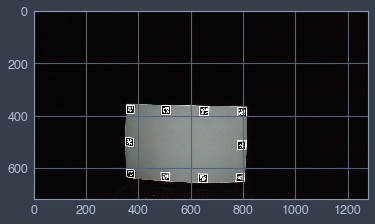

In [76]:
image = cv2.imread(frames_path + '/frame' + str(4154) + '.png')
plt.imshow(image)

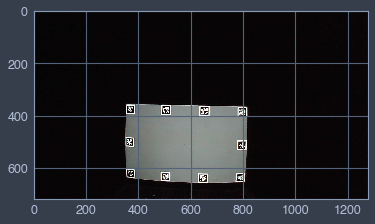

In [77]:
image = cv2.imread(frames_path + '/frame' + str(4155) + '.png')
plt.imshow(image)

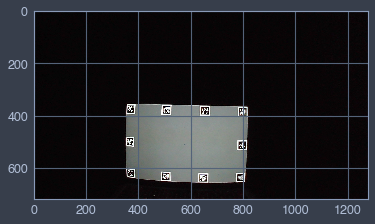

In [78]:
image = cv2.imread(frames_path + '/frame' + str(4156) + '.png')
plt.imshow(image)

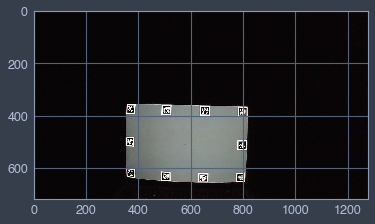

In [79]:
image = cv2.imread(frames_path + '/frame' + str(4157) + '.png')
plt.imshow(image)

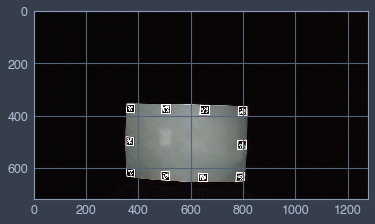

In [80]:
image = cv2.imread(frames_path + '/frame' + str(4158) + '.png')
plt.imshow(image)

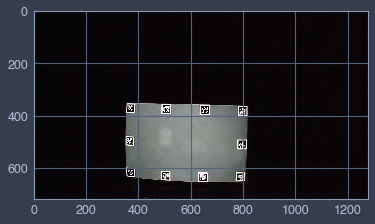

In [81]:
image = cv2.imread(frames_path + '/frame' + str(4159) + '.png')
plt.imshow(image)

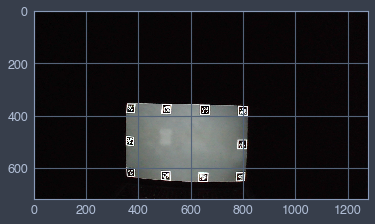

In [82]:
image = cv2.imread(frames_path + '/frame' + str(4160) + '.png')
plt.imshow(image)

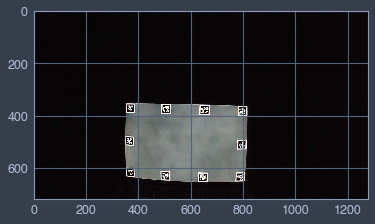

In [83]:
image = cv2.imread(frames_path + '/frame' + str(4161) + '.png')
plt.imshow(image)

## Trial 2 

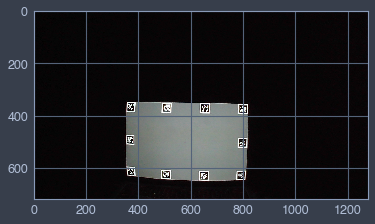

In [84]:
image = cv2.imread(frames_path + '/frame' + str(4212) + '.png')
plt.imshow(image)

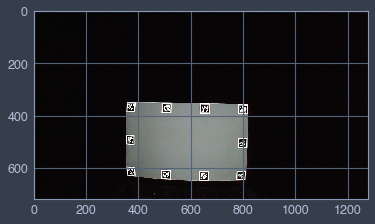

In [85]:
image = cv2.imread(frames_path + '/frame' + str(4213) + '.png')
plt.imshow(image)

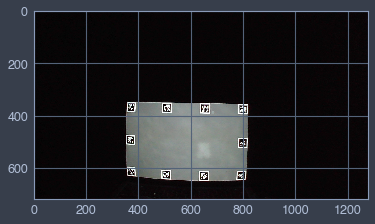

In [86]:
image = cv2.imread(frames_path + '/frame' + str(4214) + '.png')
plt.imshow(image)

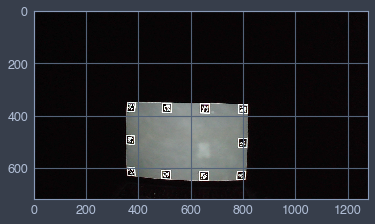

In [87]:
image = cv2.imread(frames_path + '/frame' + str(4215) + '.png')
plt.imshow(image)

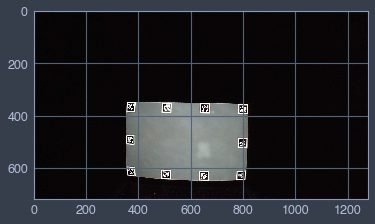

In [88]:
image = cv2.imread(frames_path + '/frame' + str(4216) + '.png')
plt.imshow(image)

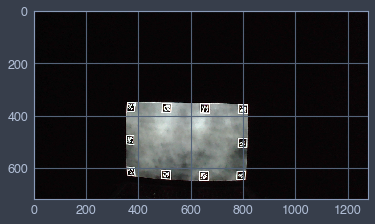

In [89]:
image = cv2.imread(frames_path + '/frame' + str(4217) + '.png')
plt.imshow(image)

## Trial 3 

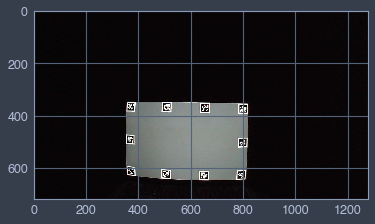

In [90]:
image = cv2.imread(frames_path + '/frame' + str(4261) + '.png')
plt.imshow(image)

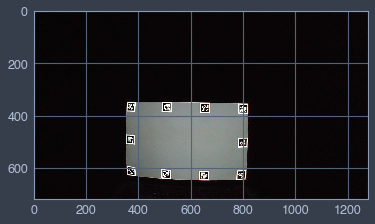

In [91]:
image = cv2.imread(frames_path + '/frame' + str(4262) + '.png')
plt.imshow(image)

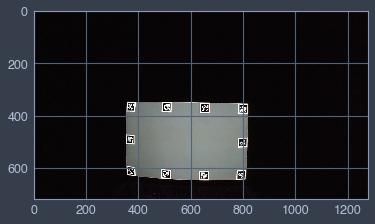

In [92]:
image = cv2.imread(frames_path + '/frame' + str(4263) + '.png')
plt.imshow(image)

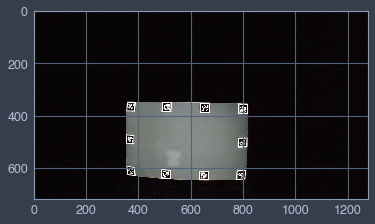

In [93]:
image = cv2.imread(frames_path + '/frame' + str(4264) + '.png')
plt.imshow(image)

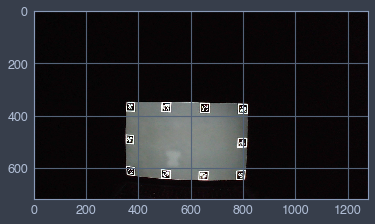

In [94]:
image = cv2.imread(frames_path + '/frame' + str(4265) + '.png')
plt.imshow(image)

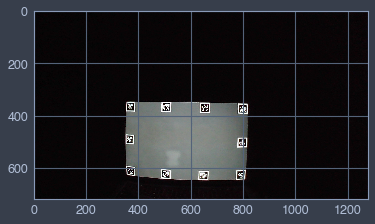

In [95]:
image = cv2.imread(frames_path + '/frame' + str(4266) + '.png')
plt.imshow(image)

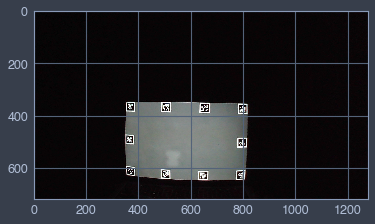

In [96]:
image = cv2.imread(frames_path + '/frame' + str(4267) + '.png')
plt.imshow(image)

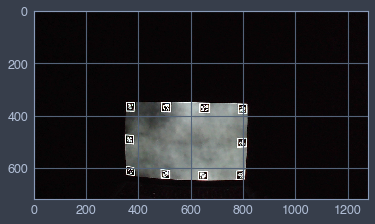

In [97]:
image = cv2.imread(frames_path + '/frame' + str(4268) + '.png')
plt.imshow(image)

## Trial 4 

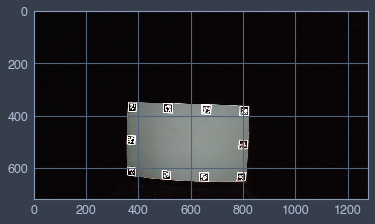

In [98]:
image = cv2.imread(frames_path + '/frame' + str(4314) + '.png')
plt.imshow(image)

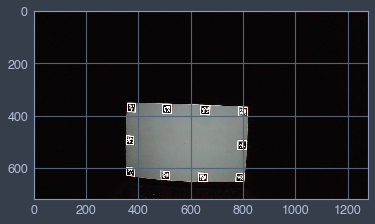

In [99]:
image = cv2.imread(frames_path + '/frame' + str(4315) + '.png')
plt.imshow(image)

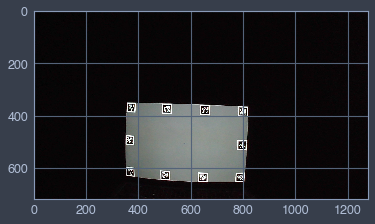

In [100]:
image = cv2.imread(frames_path + '/frame' + str(4316) + '.png')
plt.imshow(image)

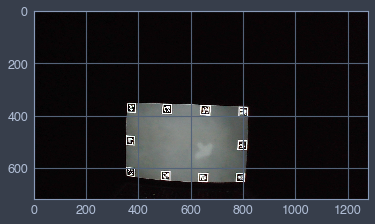

In [101]:
image = cv2.imread(frames_path + '/frame' + str(4317) + '.png')
plt.imshow(image)

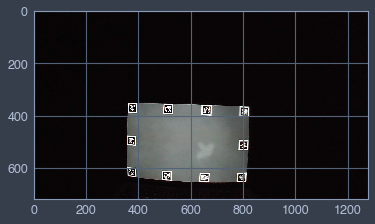

In [102]:
image = cv2.imread(frames_path + '/frame' + str(4318) + '.png')
plt.imshow(image)

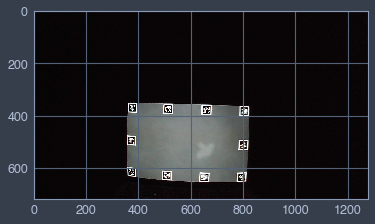

In [103]:
image = cv2.imread(frames_path + '/frame' + str(4319) + '.png')
plt.imshow(image)

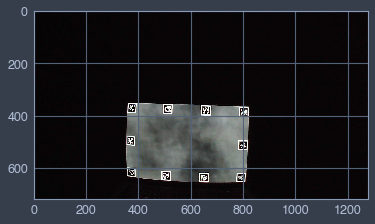

In [104]:
image = cv2.imread(frames_path + '/frame' + str(4320) + '.png')
plt.imshow(image)

# Using functions

In [105]:
fr_temp = frames_path + '/frame' + str(4319) + '.png'
center_blob, top_left_blob, bottom_right_blob = find_blob(fr_temp,correct_tags, angle=340, draw=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


# Trial loop 

In [106]:
trial_unique = behavioral_data.trialNumber.unique()
block_unique = behavioral_data.blockNumber.unique()

numBlocks = len(block_unique)
numTrials = len(trial_unique)

totalNumTrials = len(behavioral_data)

## Without lag correction 

In [107]:
coordinates_df = pd.DataFrame()
utils.print_progress_bar(0, totalNumTrials, prefix='Progress:', suffix='Complete', length=50)
tot_trial = 0
row = 0
for block in block_unique:
    if not np.isnan(block):
#         print('Processing block ' + str(block) + ' out of ' + str(len(block_unique)))

        for trial in trial_unique:
            if not np.isnan(trial):
                # find frames where trial happens
                trial_data = annotation_data[(annotation_data['block'] == block) & (annotation_data['trial'] == trial)]
                image_onset_frame = int(trial_data.loc[trial_data['task'] == 'Image onset', 'frame'])

                # find where image onset finishes
                image_offset_frame = int(trial_data.loc[trial_data['task'] == 'Adjust task', 'frame'])

                # now that we have the frames, lay them in a variable:
                selected_frames = np.arange(image_onset_frame,image_offset_frame,1)

                # find angle in behavioral data
                angle_trial = int(behavioral_data.loc[
                    (behavioral_data['blockNumber'] == block) & (behavioral_data['trialNumber'] == trial), 'stimLocationDeg'])

                # we want to find the blob for all frames during image onset
                numFrames = len(selected_frames)

                count_in_trial = 0
                for frame in selected_frames:

                    # first define path to that frame
                    fr_temp = frames_path + '/frame' + str(frame) + '.png'

                    # find blob for that frame, input the angle in that trial
                    center_blob, top_left_blob, bottom_right_blob = find_blob(fr_temp,correct_tags,
                                                                              angle=angle_trial, draw=True,
                                                                             progress_bar=False)

                    # if we couldn't find at least 10 tags:
                    if center_blob == 'Error':
                        
                        # if it's not the first one in trial, just copy the one before
                        if count_in_trial != 0:
                            coordinates_df.loc[row, 'BLOCK'] = coordinates_df.loc[row-1, 'BLOCK']
                            coordinates_df.loc[row, 'TRIAL'] = coordinates_df.loc[row-1, 'TRIAL']
                            coordinates_df.loc[row, 'ANGLE'] = coordinates_df.loc[row-1, 'ANGLE']
                            coordinates_df.loc[row, 'ORDER'] = count_in_trial
                            coordinates_df.loc[row, 'CENTER_BLOB_X'] = coordinates_df.loc[row-1, 'CENTER_BLOB_X']
                            coordinates_df.loc[row, 'CENTER_BLOB_Y'] = coordinates_df.loc[row-1, 'CENTER_BLOB_Y']
                            coordinates_df.loc[row, 'TOP_LEFT_BLOB_X'] = coordinates_df.loc[row-1, 'TOP_LEFT_BLOB_X']
                            coordinates_df.loc[row, 'TOP_LEFT_BLOB_Y'] = coordinates_df.loc[row-1, 'TOP_LEFT_BLOB_Y']
                            coordinates_df.loc[row, 'BOTTOM_RIGHT_BLOB_X'] =  coordinates_df.loc[row-1, 'BOTTOM_RIGHT_BLOB_X']
                            coordinates_df.loc[row, 'BOTTOM_RIGHT_BLOB_Y'] =  coordinates_df.loc[row-1, 'BOTTOM_RIGHT_BLOB_Y']
                        
                        elif count_in_trial == 0: # if it is indeed the first trial, then have the same as next trial                   
                            coordinates_df.loc[row, 'BLOCK'] = float('nan')
                            coordinates_df.loc[row, 'TRIAL'] = float('nan')
                            coordinates_df.loc[row, 'ANGLE'] = float('nan')
                            coordinates_df.loc[row, 'ORDER'] = float('nan')
                            coordinates_df.loc[row, 'CENTER_BLOB_X'] = float('nan')
                            coordinates_df.loc[row, 'CENTER_BLOB_Y'] = float('nan')
                            coordinates_df.loc[row, 'TOP_LEFT_BLOB_X'] = float('nan')
                            coordinates_df.loc[row, 'TOP_LEFT_BLOB_Y'] = float('nan')
                            coordinates_df.loc[row, 'BOTTOM_RIGHT_BLOB_X'] =  float('nan')
                            coordinates_df.loc[row, 'BOTTOM_RIGHT_BLOB_Y'] =  float('nan')
                    else:
                        coordinates_df.loc[row, 'BLOCK'] = block
                        coordinates_df.loc[row, 'TRIAL'] = trial
                        coordinates_df.loc[row, 'ANGLE'] = angle_trial
                        coordinates_df.loc[row, 'ORDER'] = count_in_trial
                        coordinates_df.loc[row, 'CENTER_BLOB_X'] = center_blob[0]
                        coordinates_df.loc[row, 'CENTER_BLOB_Y'] = center_blob[1]
                        coordinates_df.loc[row, 'TOP_LEFT_BLOB_X'] = top_left_blob[0]
                        coordinates_df.loc[row, 'TOP_LEFT_BLOB_Y'] = top_left_blob[1]
                        coordinates_df.loc[row, 'BOTTOM_RIGHT_BLOB_X'] =  bottom_right_blob[0]
                        coordinates_df.loc[row, 'BOTTOM_RIGHT_BLOB_Y'] =  bottom_right_blob[1]


                    count_in_trial += 1
                    row += 1
                    
            tot_trial += 1
            utils.print_progress_bar(tot_trial, totalNumTrials, prefix='Progress:', suffix='Complete', length=50)






Progress: |██████████████████████████████████████████████████| 100.0% Complete


## with lag correction

In [123]:
#apply lag to all the times
annotation_data["fixlag"] = annotation_data['timestamp'] - np.abs(timesCG["delay"].mean())

#round new times
annotation_data["round_fixlag"] = round(annotation_data["fixlag"], 4)

#find nearest frame that has the new rounded time
for annotation_idx in range(len(annotation_data)):
    
    msg = annotation_data.loc[annotation_idx, 'exp_event']
    msg_ts = annotation_data.loc[annotation_idx, 'round_fixlag']
    
    closest_ts = numbers.closest(world_timestamps_df['TIMESTAMP'], msg_ts)
    # find frame:
    msg_frame = int(world_timestamps_df.loc[world_timestamps_df['TIMESTAMP'] == closest_ts, 'FRAME'])
    
    annotation_data.loc[annotation_idx, 'shifted_frames'] = msg_frame

In [124]:
#setup
coordinates_df_fixlag = pd.DataFrame()
utils.print_progress_bar(0, totalNumTrials, prefix='Progress:', suffix='Complete', length=50)
tot_trial = 0
row = 0

for block in block_unique:
    if not np.isnan(block):
        for trial in trial_unique:
            if not np.isnan(trial):
                # find the frames where trial happens
                trial_data = annotation_data[(annotation_data['block'] == block) & (annotation_data['trial'] == trial)]
                image_onset_frame = int(trial_data.loc[trial_data['task'] == 'Image onset', 'shifted_frames'])

                # find where the image onset finishes
                image_offset_frame = int(trial_data.loc[trial_data['task'] == 'Adjust task', 'shifted_frames'])

                # arange with all variables
                selected_frames = np.arange(image_onset_frame,image_offset_frame,1)

                # angle in behavioral data
                angle_trial = int(behavioral_data.loc[
                    (behavioral_data['blockNumber'] == block) & (behavioral_data['trialNumber'] == trial), 'stimLocationDeg'])

                # all frames
                numFrames = len(selected_frames)

                count_in_trial = 0
                for frame in selected_frames:

                    # frame path
                    fr_temp = frames_path + '/frame' + str(frame) + '.png'

                    # find blob for frame, input the angle in that trial
                    center_blob, top_left_blob, bottom_right_blob = find_blob(fr_temp,correct_tags,
                                                                              angle=angle_trial, draw=True,
                                                                             progress_bar=False)

                    # if we couldn't find at least 10 tags/incomplete pictures:
                    if center_blob == 'Error':
                        
                        # if it's not the first one in trial, just copy the one before
                        if count_in_trial != 0:
                            coordinates_df_fixlag.loc[row, 'BLOCK'] = coordinates_df_fixlag.loc[row-1, 'BLOCK']
                            coordinates_df_fixlag.loc[row, 'TRIAL'] = coordinates_df_fixlag.loc[row-1, 'TRIAL']
                            coordinates_df_fixlag.loc[row, 'ANGLE'] = coordinates_df_fixlag.loc[row-1, 'ANGLE']
                            coordinates_df_fixlag.loc[row, 'ORDER'] = count_in_trial
                            coordinates_df_fixlag.loc[row, 'CENTER_BLOB_X'] = coordinates_df_fixlag.loc[row-1, 'CENTER_BLOB_X']
                            coordinates_df_fixlag.loc[row, 'CENTER_BLOB_Y'] = coordinates_df_fixlag.loc[row-1, 'CENTER_BLOB_Y']
                            coordinates_df_fixlag.loc[row, 'TOP_LEFT_BLOB_X'] = coordinates_df_fixlag.loc[row-1, 'TOP_LEFT_BLOB_X']
                            coordinates_df_fixlag.loc[row, 'TOP_LEFT_BLOB_Y'] = coordinates_df_fixlag.loc[row-1, 'TOP_LEFT_BLOB_Y']
                            coordinates_df_fixlag.loc[row, 'BOTTOM_RIGHT_BLOB_X'] =  coordinates_df_fixlag.loc[row-1, 'BOTTOM_RIGHT_BLOB_X']
                            coordinates_df_fixlag.loc[row, 'BOTTOM_RIGHT_BLOB_Y'] =  coordinates_df_fixlag.loc[row-1, 'BOTTOM_RIGHT_BLOB_Y']
                        
                        elif count_in_trial == 0: # if it is indeed the first trial, then have the same as next trial                   
                            coordinates_df_fixlag.loc[row, 'BLOCK'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'TRIAL'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'ANGLE'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'ORDER'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'CENTER_BLOB_X'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'CENTER_BLOB_Y'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'TOP_LEFT_BLOB_X'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'TOP_LEFT_BLOB_Y'] = float('nan')
                            coordinates_df_fixlag.loc[row, 'BOTTOM_RIGHT_BLOB_X'] =  float('nan')
                            coordinates_df_fixlag.loc[row, 'BOTTOM_RIGHT_BLOB_Y'] =  float('nan')
                    else:
                        coordinates_df_fixlag.loc[row, 'BLOCK'] = block
                        coordinates_df_fixlag.loc[row, 'TRIAL'] = trial
                        coordinates_df_fixlag.loc[row, 'ANGLE'] = angle_trial
                        coordinates_df_fixlag.loc[row, 'ORDER'] = count_in_trial
                        coordinates_df_fixlag.loc[row, 'CENTER_BLOB_X'] = center_blob[0]
                        coordinates_df_fixlag.loc[row, 'CENTER_BLOB_Y'] = center_blob[1]
                        coordinates_df_fixlag.loc[row, 'TOP_LEFT_BLOB_X'] = top_left_blob[0]
                        coordinates_df_fixlag.loc[row, 'TOP_LEFT_BLOB_Y'] = top_left_blob[1]
                        coordinates_df_fixlag.loc[row, 'BOTTOM_RIGHT_BLOB_X'] =  bottom_right_blob[0]
                        coordinates_df_fixlag.loc[row, 'BOTTOM_RIGHT_BLOB_Y'] =  bottom_right_blob[1]


                    count_in_trial += 1
                    row += 1
                    
            tot_trial += 1
            utils.print_progress_bar(tot_trial, totalNumTrials, prefix='Progress:', suffix='Complete', length=50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
